In [1]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse('j_caesar.xml')
root = tree.getroot()

# Dictionary to hold merged speeches by speaker
speeches_by_speaker = {}

# Iterate over all speeches in all acts and scenes
for act in root.findall('ACT'):
    for scene in act.findall('SCENE'):
        for speech in scene.findall('SPEECH'):
            speaker = speech.find('SPEAKER').text.strip()
            if speaker.isupper():
                lines = [line.text.strip() for line in speech.findall('LINE') if line.text]
                speech_text = " ".join(lines)
                
                # Merge speeches into one long string per speaker
                if speaker in speeches_by_speaker:
                    speeches_by_speaker[speaker] += " " + speech_text
                else:
                    speeches_by_speaker[speaker] = speech_text

import csv

# Path for saving CSV
csv_path = 'j_caesar_speeches.csv'

# Write dictionary to CSV with two columns: Speaker, Speech
with open(csv_path, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Speaker', 'Speech'])  # header
    for speaker, speech_text in speeches_by_speaker.items():
        writer.writerow([speaker, speech_text])

print(f"Saved speeches to {csv_path}")

# Print number of words for each speaker
for speaker, speech_text in speeches_by_speaker.items():
    word_count = len(speech_text.split())
    print(f"{speaker}: {word_count} words")

Saved speeches to j_caesar_speeches.csv
FLAVIUS: 198 words
MARULLUS: 238 words
CAESAR: 989 words
CASCA: 1052 words
CALPURNIA: 202 words
ANTONY: 2539 words
BRUTUS: 5395 words
CASSIUS: 3857 words
CICERO: 63 words
CINNA: 130 words
LUCIUS: 205 words
DECIUS BRUTUS: 323 words
METELLUS CIMBER: 121 words
TREBONIUS: 60 words
PORTIA: 720 words
LIGARIUS: 111 words
PUBLIUS: 6 words
ARTEMIDORUS: 145 words
POPILIUS: 10 words
CINNA THE POET: 104 words
OCTAVIUS: 328 words
LEPIDUS: 22 words
LUCILIUS: 174 words
PINDARUS: 112 words
MESSALA: 246 words
TITINIUS: 237 words
VARRO: 31 words
GHOST: 16 words
CLAUDIUS: 6 words
CATO: 54 words
CLITUS: 70 words
DARDANIUS: 15 words
VOLUMNIUS: 17 words
STRATO: 59 words


In [2]:
import torch
from transformers import LongformerTokenizer, LongformerModel

# Load pre-trained Longformer model + tokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

def embed_text(text, tokenizer, model, device='cpu', max_tokens=4096):
    # Tokenize and split if text exceeds max_tokens
    tokens = tokenizer(
        text, 
        return_tensors='pt',
        truncation=False,
        add_special_tokens=True
    )
    input_ids = tokens['input_ids'][0]
    
    # If too long, chunk by max_tokens (including special tokens)
    if len(input_ids) > max_tokens:
        chunks = [input_ids[i:i+max_tokens] for i in range(0, len(input_ids), max_tokens)]
    else:
        chunks = [input_ids]
    
    embeddings = []
    for chunk in chunks:
        chunk = chunk.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(chunk)
            # Use the [CLS]-like embedding (Longformer doesn't have an official CLS, but first token works for global info)
            cls_embedding = output.last_hidden_state[:, 0, :]   # shape: [1, hidden_size]
            embeddings.append(cls_embedding.squeeze(0).cpu().numpy())
    
    # Average embeddings if multiple chunks
    final_embedding = sum(embeddings) / len(embeddings)
    return final_embedding

# Example usage for your speeches dictionary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# speeches_by_speaker: dict {speaker: full speech text}
character_embeddings = {}
for speaker, speech_text in speeches_by_speaker.items():
    embedding = embed_text(speech_text, tokenizer, model, device=device)
    character_embeddings[speaker] = embedding
    print(f"{speaker} embedding shape: {embedding.shape}")

Input ids are automatically padded to be a multiple of `config.attention_window`: 512


FLAVIUS embedding shape: (768,)
MARULLUS embedding shape: (768,)
CAESAR embedding shape: (768,)
CASCA embedding shape: (768,)
CALPURNIA embedding shape: (768,)
ANTONY embedding shape: (768,)
BRUTUS embedding shape: (768,)
CASSIUS embedding shape: (768,)
CICERO embedding shape: (768,)
CINNA embedding shape: (768,)
LUCIUS embedding shape: (768,)
DECIUS BRUTUS embedding shape: (768,)
METELLUS CIMBER embedding shape: (768,)
TREBONIUS embedding shape: (768,)
PORTIA embedding shape: (768,)
LIGARIUS embedding shape: (768,)
PUBLIUS embedding shape: (768,)
ARTEMIDORUS embedding shape: (768,)
POPILIUS embedding shape: (768,)
CINNA THE POET embedding shape: (768,)
OCTAVIUS embedding shape: (768,)
LEPIDUS embedding shape: (768,)
LUCILIUS embedding shape: (768,)
PINDARUS embedding shape: (768,)
MESSALA embedding shape: (768,)
TITINIUS embedding shape: (768,)
VARRO embedding shape: (768,)
GHOST embedding shape: (768,)
CLAUDIUS embedding shape: (768,)
CATO embedding shape: (768,)
CLITUS embedding sha

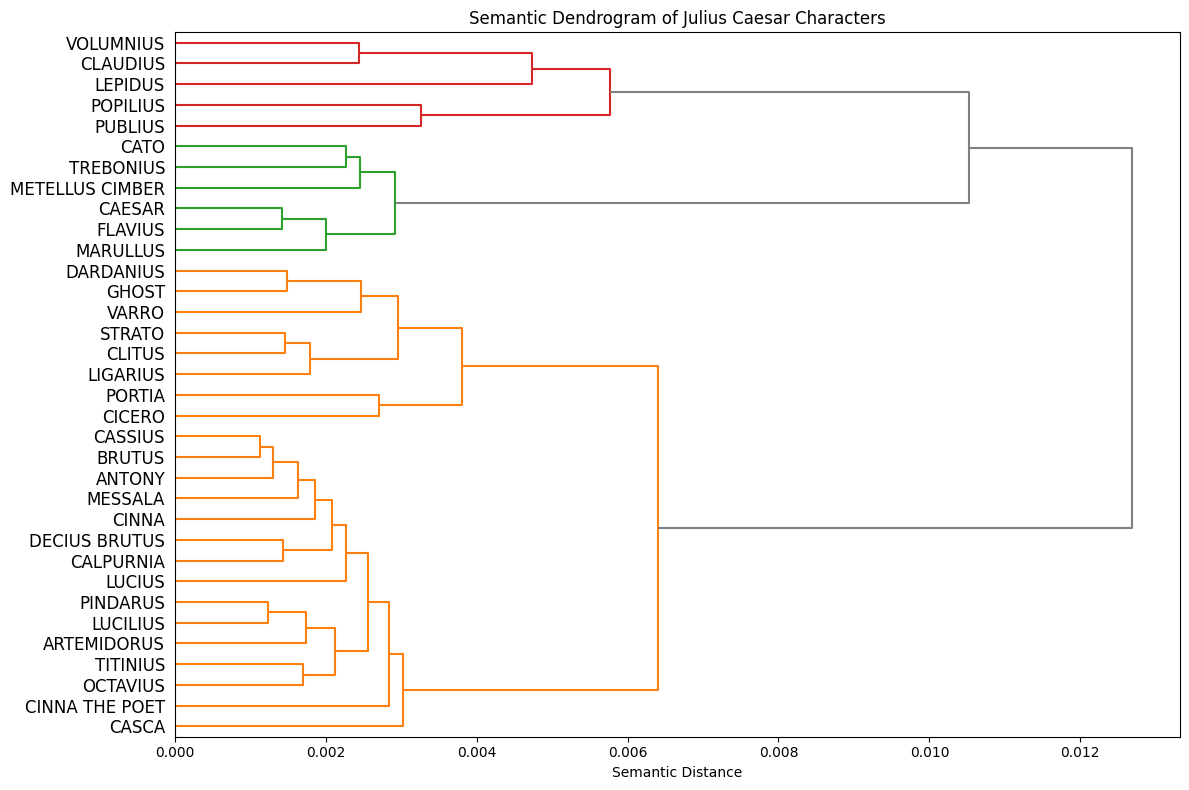

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 1. Create embedding matrix and label list
characters = list(character_embeddings.keys())
embeddings = np.stack([character_embeddings[char] for char in characters])

# 2. Compute semantic distance matrix
similarity_matrix = cosine_similarity(embeddings)
distance_matrix = 1 - similarity_matrix

# 3. Compute linkage (hierarchical clustering)
# Convert the square distance matrix to a condensed form as required by linkage
from scipy.spatial.distance import squareform
condensed_dist = squareform(distance_matrix, checks=False)
Z = linkage(condensed_dist, method='ward')  # 'ward', 'average', etc.

# 4. Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    labels=characters,
    orientation='right',
    leaf_font_size=12,
    color_threshold=None,   # set for automatic coloring, or choose a threshold
    above_threshold_color='grey'
)
plt.title("Semantic Dendrogram of Julius Caesar Characters")
plt.xlabel("Semantic Distance")
plt.tight_layout()
plt.show()

In [4]:
import nltk
from transformers import pipeline
import numpy as np
import pandas as pd

# Emotion pipeline
emotion_pipe = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

def split_text_into_chunks(text, max_words=200, overlap=50):
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + max_words, len(words))
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        if end == len(words): break
        start += max_words - overlap  # overlap for sliding window
    return chunks

def get_aggregate_emotion(text):
    chunks = split_text_into_chunks(text)
    all_scores = []
    for chunk in chunks:
        result = emotion_pipe(chunk)
        emotion_scores = {r['label']: r['score'] for r in result[0]}
        all_scores.append(emotion_scores)
    # Aggregate by mean
    all_labels = all_scores[0].keys()
    avg_scores = {label: np.mean([score[label] for score in all_scores]) for label in all_labels}
    return avg_scores

# --- Integration into your main loop ---
character_emotions = {}

for speaker, speech_text in speeches_by_speaker.items():
    avg_emotions = get_aggregate_emotion(speech_text)
    character_emotions[speaker] = avg_emotions
    print(f"{speaker}: {avg_emotions}")  # Optional: progress output

# Optionally, convert to DataFrame and save
emotions_df = pd.DataFrame(character_emotions).T  # Speakers as rows
emotions_df.to_csv("julius_caesar_character_emotions.csv")

Device set to use cuda:0
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


FLAVIUS: {'anger': 0.3151409924030304, 'disgust': 0.09215551614761353, 'fear': 0.18505051732063293, 'joy': 0.029078809544444084, 'neutral': 0.23484967648983002, 'sadness': 0.12961061298847198, 'surprise': 0.014113795943558216}
MARULLUS: {'anger': 0.35868738032877445, 'disgust': 0.05134363006800413, 'fear': 0.4465167932212353, 'joy': 0.022777440957725048, 'neutral': 0.03991054929792881, 'sadness': 0.04230485763400793, 'surprise': 0.038459328934550285}
CAESAR: {'anger': 0.1620511087988104, 'disgust': 0.09137827287694174, 'fear': 0.5157945012407643, 'joy': 0.027321167872287333, 'neutral': 0.09255034622869321, 'sadness': 0.09693562771592822, 'surprise': 0.013968978393157678}
CASCA: {'anger': 0.3080039456752794, 'disgust': 0.20577726157249085, 'fear': 0.3475471974483558, 'joy': 0.0056598752271384, 'neutral': 0.05914039354372237, 'sadness': 0.049970388146383424, 'surprise': 0.023900936723553708}
CALPURNIA: {'anger': 0.00787123991176486, 'disgust': 0.003296499140560627, 'fear': 0.966985553503

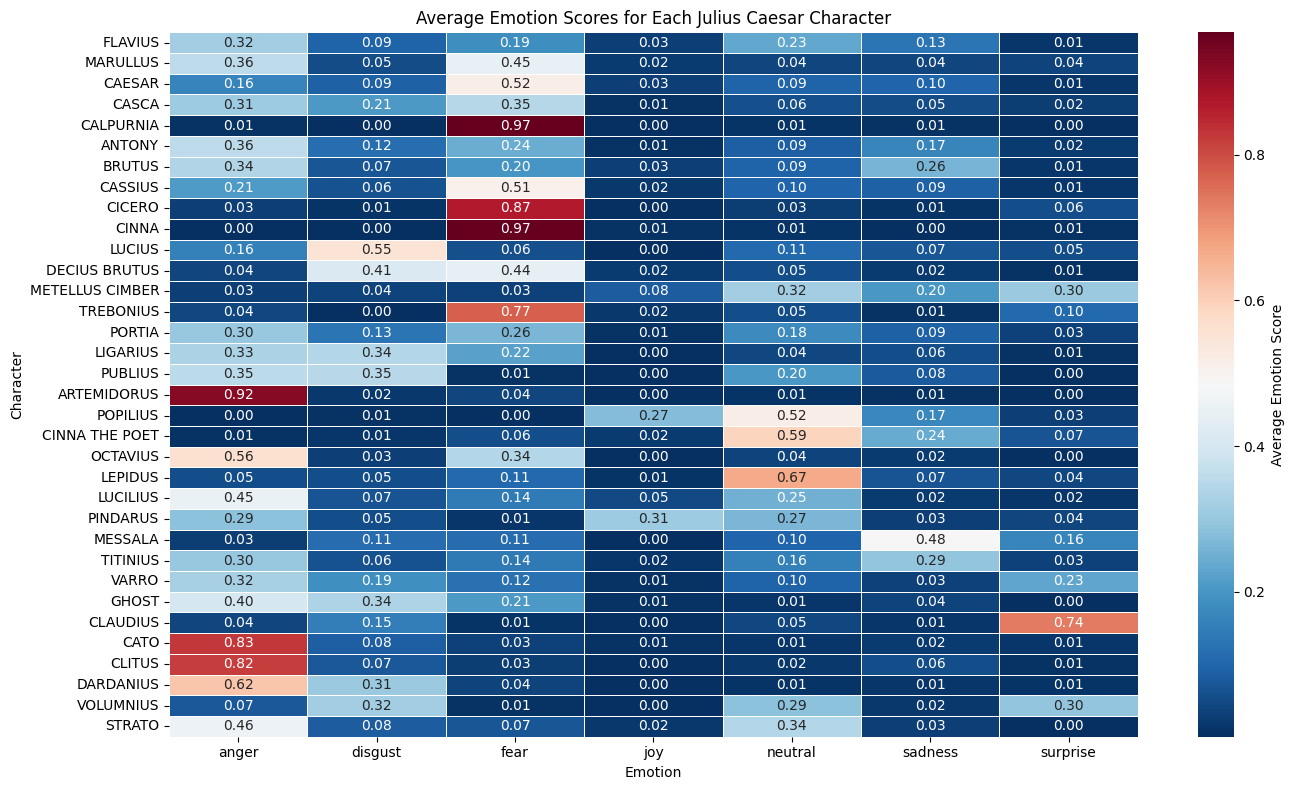

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace NaN with 0 (just in case some emotions are missing for some speakers)
emotions_df_filled = emotions_df.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(emotions_df_filled, 
            cmap="RdBu_r", 
            annot=True, 
            fmt=".2f", 
            linewidths=.5, 
            cbar_kws={'label': 'Average Emotion Score'})
plt.title("Average Emotion Scores for Each Julius Caesar Character")
plt.xlabel("Emotion")
plt.ylabel("Character")
plt.tight_layout()
plt.show()


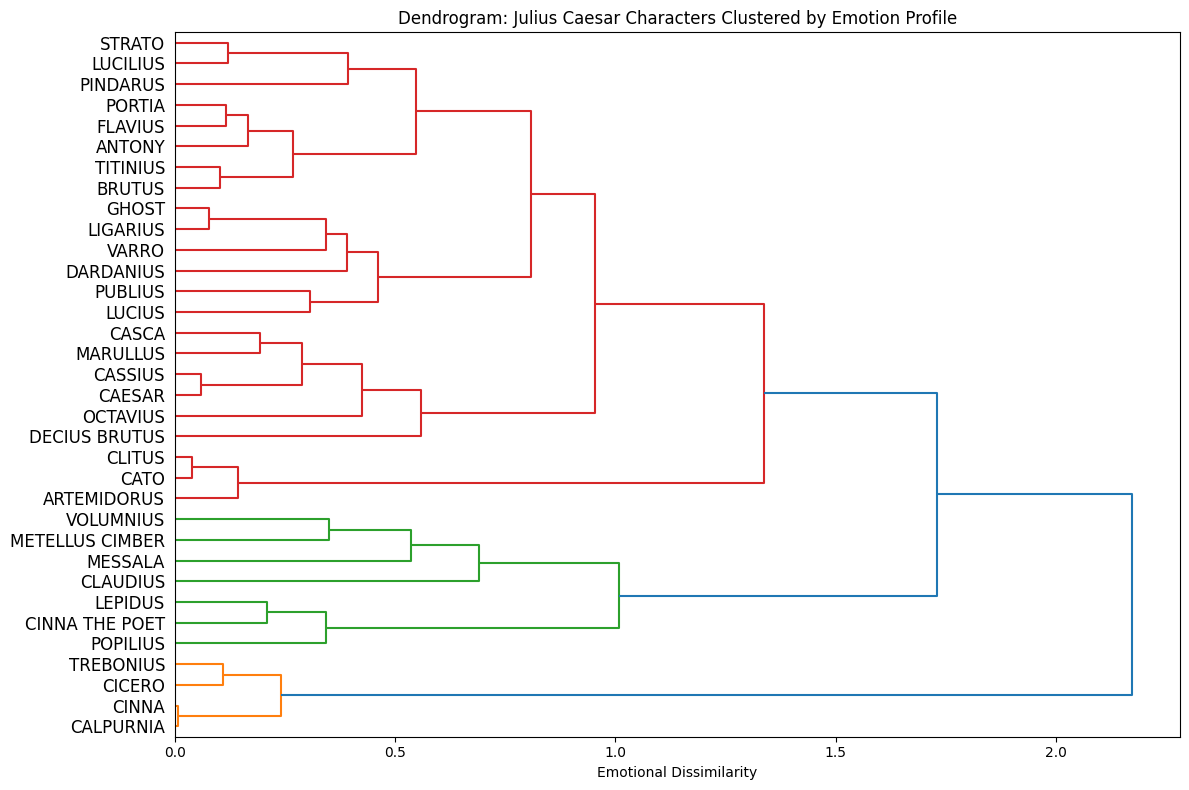

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Remove characters with all zeros or missing values to avoid clustering artifacts
filtered_emotions = emotions_df.fillna(0)
filtered_emotions = filtered_emotions.loc[filtered_emotions.sum(axis=1) > 0]

# Compute hierarchical clustering linkage matrix
Z = linkage(filtered_emotions.values, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z, 
    labels=filtered_emotions.index.tolist(), 
    orientation='right',
    leaf_font_size=12
)
plt.title("Dendrogram: Julius Caesar Characters Clustered by Emotion Profile")
plt.xlabel("Emotional Dissimilarity")
plt.tight_layout()
plt.show()


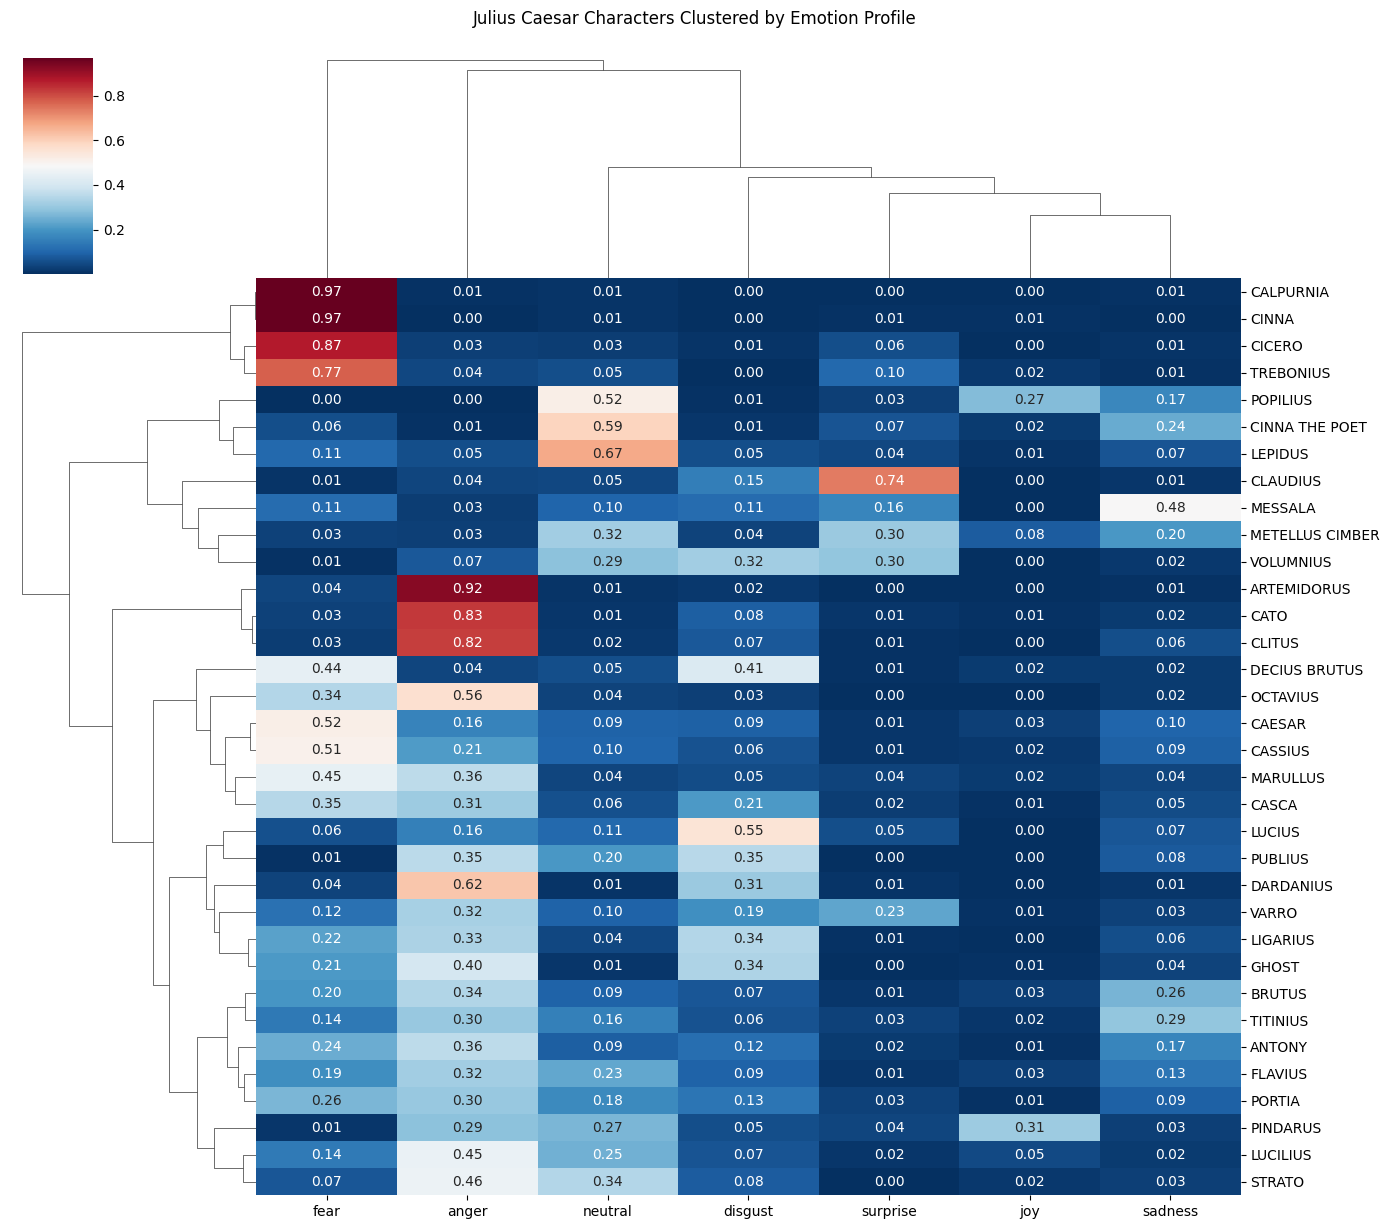

In [7]:
import seaborn as sns

sns.clustermap(
    filtered_emotions, 
    method='ward', 
    metric='euclidean',
    cmap="RdBu_r", 
    figsize=(14, 12),
    annot=True, 
    fmt=".2f"
)
plt.suptitle("Julius Caesar Characters Clustered by Emotion Profile", y=1.02)
plt.show()

['ANTONY', 'BRUTUS', 'CASSIUS']


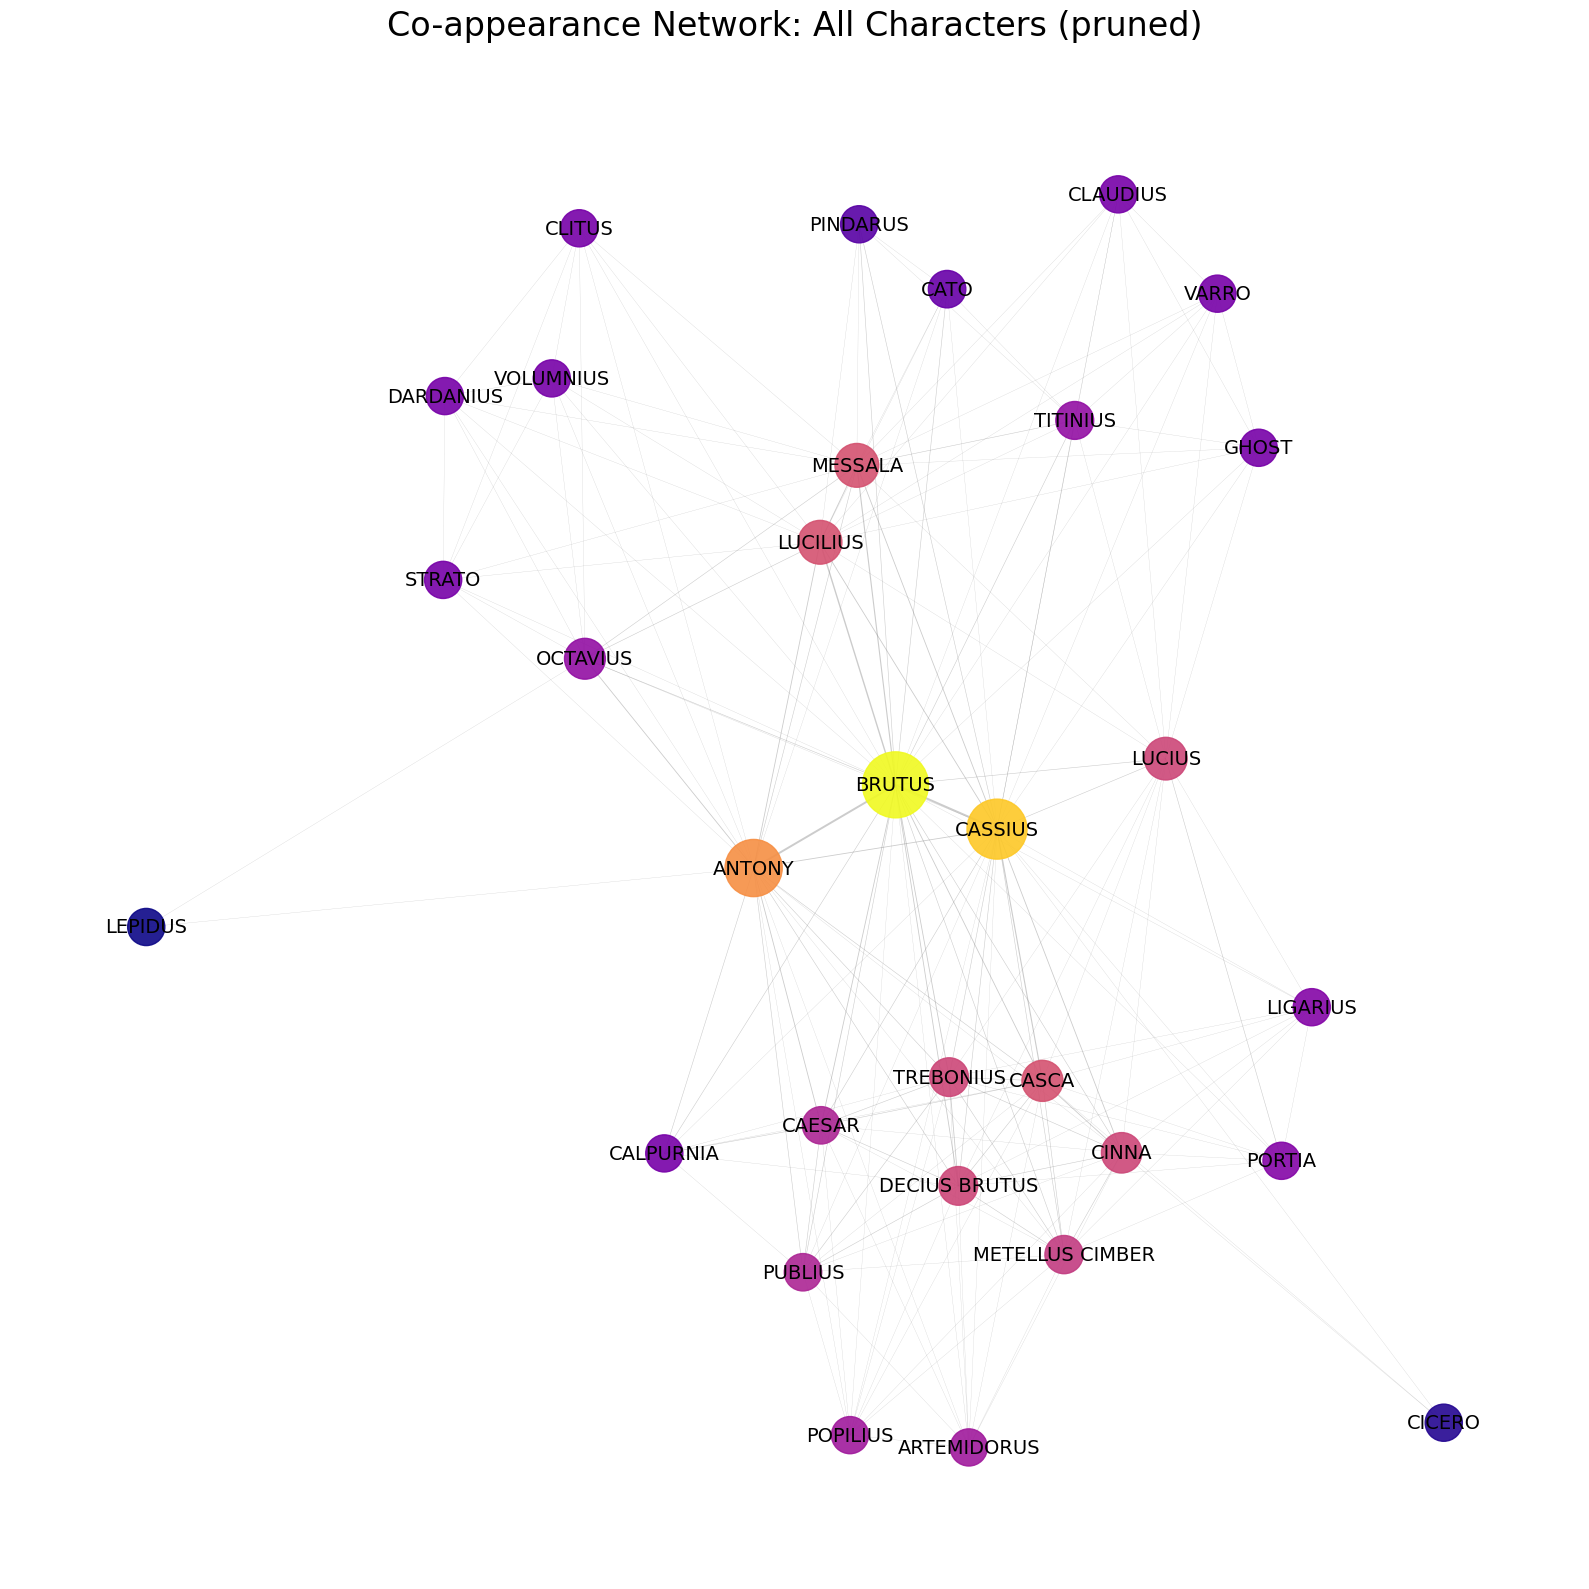

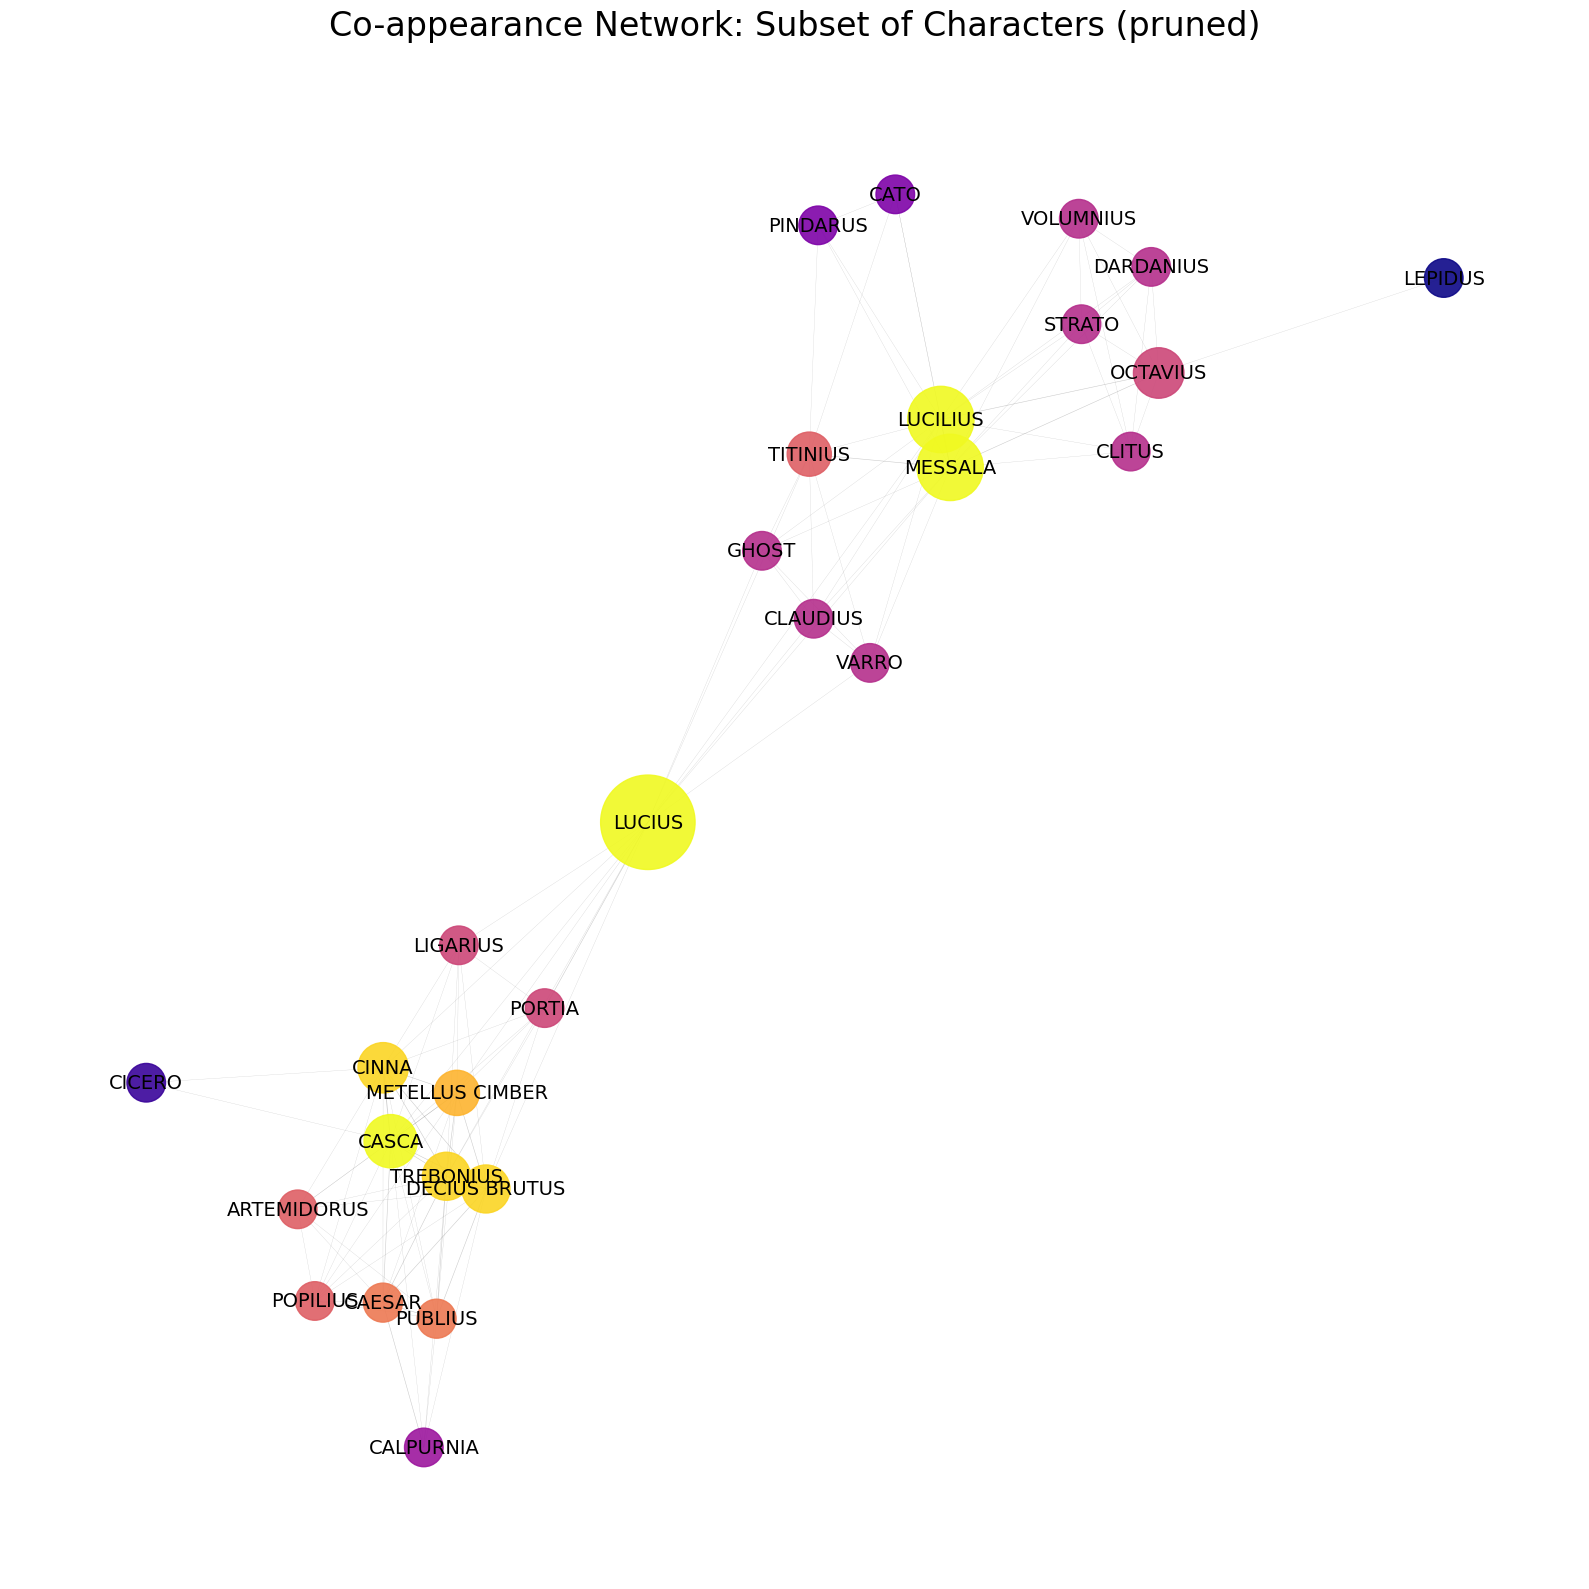

In [25]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Parse the Julius Caesar XML into a DataFrame
tree = ET.parse('j_caesar.xml')
root = tree.getroot()

records = []
for act in root.findall('ACT'):
    act_label = act.find('TITLE').text.strip() if act.find('TITLE') is not None else act.get('ID', 'Act')
    for scene in act.findall('SCENE'):
        scene_label = scene.find('TITLE').text.strip() if scene.find('TITLE') is not None else scene.get('ID', 'Scene')
        for speech in scene.findall('SPEECH'):
            speaker = speech.find('SPEAKER').text.strip()
            if speaker.isupper():
                if speaker != 'FLAVIUS':
                    if speaker != 'MARRULUS':
                        records.append({
                            'Act': act_label,
                            'Scene': scene_label,
                            'Player': speaker
                        })

single_play = pd.DataFrame(records)

# 2. Build co-occurrence graph
def graphify(characters):
    G = nx.Graph()
    G.add_nodes_from(characters)
    # count appearances per act/scene/player
    scenes_df = single_play.groupby(['Act', 'Scene', 'Player']).size()
    # restrict to only the given characters
    scenes_df = scenes_df.loc[:, :, characters]
    # for each scene, link every pair of characters present
    for (act, scene), counts in scenes_df.groupby(['Act', 'Scene']):
        chars_in_scene = counts.index.get_level_values('Player').tolist()
        for a, b in combinations(chars_in_scene, 2):
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)
    # remove any characters who never co-appear
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

# 3. Prepare character lists
all_characters = single_play['Player'].unique().tolist()
to_drop_idx = [4, 5, 6]
to_drop = [all_characters[i] for i in to_drop_idx if i < len(all_characters)]
print(to_drop)
subset_chars = [c for c in all_characters if c not in to_drop]

# 4. Generate graphs (with isolates removed)
wChars = graphify(all_characters)
woChars = graphify(subset_chars)

# 5. Enhanced visualization
def draw_beautiful_graph(G, title):
    # compute layout
    pos = nx.spring_layout(G, seed=42, k=0.3, iterations=100)
    # centrality and degree metrics
    bet = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    deg = dict(G.degree())
    # map to node sizes & colors
    node_sizes = [bet[n] * 8000 + 200 for n in G.nodes()]
    node_colors = [deg[n] for n in G.nodes()]
    # edge widths by weight
    edge_widths = [G[u][v]['weight'] * 0.2 for u, v in G.edges()]

    plt.figure(figsize=(16, 16), facecolor='white')
    # edges
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.4,
                           edge_color='grey')
    # nodes
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           cmap=plt.cm.plasma,
                           alpha=0.9)
    # labels
    nx.draw_networkx_labels(G, pos,
                            font_size=14,
                            font_family='sans-serif')
    plt.title(title, fontsize=24, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 6. Draw both networks
#draw_beautiful_graph(wChars, 'Co-appearance Network: All Characters (pruned)')
draw_beautiful_graph(woChars, 'Co-appearance Network: Subset of Characters (pruned)')